In [3]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator

from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

from dataprep import transform_indices
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

# Preparing data

In [37]:
data = get_movielens_data(include_time=True)

In [38]:
training_, holdout_ = leave_one_out(data, target='timestamp', sample_top=True, random_state=0)

assert holdout_.set_index('userid')['timestamp'].ge(
    training_
    .groupby('userid')
    ['timestamp'].max()
).all()

In [39]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = reindex(holdout_, data_index.values(), filter_invalid=True)
holdout = holdout.sort_values('userid')

Filtered 2 invalid observations.


In [40]:
holdout

,userid,movieid,rating,timestamp
25,0,47,5,978824351
87,1,1420,4,978300174
232,2,1900,4,978298504
235,3,2742,4,978294282
258,4,279,2,978246585
...,...,...,...,...
999251,6035,2440,1,956755196
999684,6036,421,3,956801840
999731,6037,1094,5,956717204
999826,6038,1162,4,956758029


In [7]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)

## PureSVD

In [8]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), dtype='f8')


def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

In [9]:
svd_config = {'rank': 200}

V, sigma = svd_params = build_svd_model(svd_config, training, data_description)

In [10]:
V.shape

(3704, 200)

In [11]:
np.testing.assert_almost_equal(
    V.T @ V,
    np.eye(svd_config['rank']), decimal=14
)

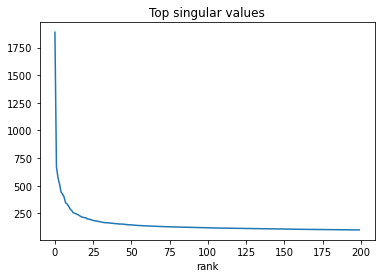

In [12]:
pd.Series(sigma).plot(title='Top singular values', xlabel='rank');

## "Shifted" PureSVD

In [13]:
def build_shifted_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    average_rating = source_matrix.data.mean() # average over all non-zeros
    centered_matrix = source_matrix._with_data(
        source_matrix.data - average_rating
    )

    def shifted_mv(v):
        return centered_matrix.dot(v) + average_rating * v.sum()

    def shifted_rmv(v):
        return centered_matrix.T.dot(v) + average_rating * v.sum()

    shifted_matrix = LinearOperator(
        source_matrix.shape,
        shifted_mv,
        shifted_rmv
    )
    _, s, vt = svds(shifted_matrix, k=config['rank'])
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values    

In [14]:
V_shift, sigma_shift = shifted_params = build_shifted_model(
    svd_config,
    training,
    data_description
)

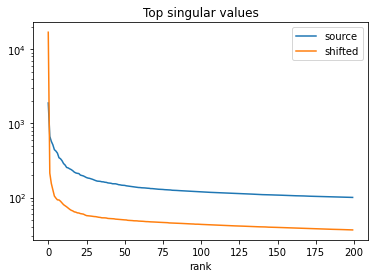

In [15]:
ax = pd.Series(sigma).plot(
    title='Top singular values',
    xlabel='rank',
    label='source',
    legend=True,
    logy=True
)
pd.Series(sigma_shift).plot(
    legend=True,
    label='shifted',
    ax=ax,
);

Let's sompare top singular value against the estimation:

In [16]:
# estimated leading singular value
training.rating.mean() * np.sqrt(data_description['n_users'] * data_description['n_items'])

16940.06604926778

In [17]:
# computed leading singular value
sigma_shift.max()

16941.71708415302

Very close!

Let's see how singular values accumulate from the end.

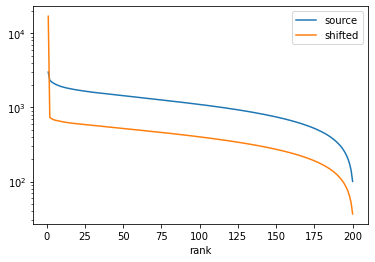

In [18]:
rev_sigma_idx = np.arange(svd_config['rank'], 0, -1)
ax = pd.Series(sigma[::-1]**2, index=rev_sigma_idx).cumsum().pow(0.5).plot(
    title='',
    xlabel='rank',
    label='source',
    legend=True,
    logy=True
)
pd.Series(sigma_shift[::-1]**2, index=rev_sigma_idx).cumsum().pow(0.5).plot(
    legend=True,
    label='shifted',
    ax=ax,
);

Let's stop here for a moment. What are possible conclusions from this graph:
1. we reduced approximation error
2. seems like we'll need lower rank value, as most of the variation is already explained by the first singular triplet.

Let's scrutinize a bit over these two conclusions.

Obviously, singular values indicate general reduction of error, which includes erros computed on unknown ratings. Let's check error only for known ratings.

In [19]:
def rmse(true_ratings, predicted):
    return np.sqrt(np.power(true_ratings - predicted, 2).mean())

def svd_predict(source_matrix, item_factors):
    nnz_user, nnz_item = source_matrix.nonzero()
    user_factors = source_matrix.dot(item_factors)
    return (user_factors[nnz_user] * item_factors[nnz_item, :]).sum(axis=1)

def compute_train_rmse(source_matrix, item_factors):
    return rmse(
        source_matrix.data,
        svd_predict(source_matrix, item_factors)
    )

In [20]:
# PureSVD
train_matrix = matrix_from_observations(training, data_description)
svd_rmse = compute_train_rmse(train_matrix, V)
print(f'{svd_rmse=:.2f}')

svd_rmse=1.81


In [21]:
def shifted_predict(source_matrix, item_factors):
    nnz_user, nnz_item = source_matrix.nonzero()
    average_rating = source_matrix.data.mean()
    centered_matrix = source_matrix._with_data(
        source_matrix.data - average_rating
    )
    user_factors = centered_matrix.dot(item_factors) + average_rating * item_factors.sum(axis=0)
    return (user_factors[nnz_user] * item_factors[nnz_item, :]).sum(axis=1)

def compute_train_rmse_shifted(source_matrix, item_factors):
    return rmse(
        source_matrix.data,
        shifted_predict(source_matrix,
        item_factors)
    )

In [22]:
# Shifted PureSVD
shifted_rmse = compute_train_rmse_shifted(train_matrix, V_shift)
print(f'{shifted_rmse=:.2f}')

shifted_rmse=0.70


Indeed, an improvement is quite substantial.

Let's evaluate with more relevant metrics:

# Evaluation 

In [23]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    train_matrix = data_description['train_matrix']
    test_users = data_description['test_users']
    test_matrix = train_matrix[test_users, :]
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

## PureSVD

In [24]:
data_description['train_matrix'] = train_matrix
test_users = holdout[data_description['users']].drop_duplicates().values
data_description['test_users'] = test_users

In [25]:
svd_scores = svd_model_scoring(svd_params, None, data_description)

In [26]:
userid = data_description['users']
testset = training.query(f'{userid} in @test_users')
downvote_seen_items(svd_scores, testset, data_description)

In [27]:
svd_recs = topn_recommendations(svd_scores, topn=10)
model_evaluate(svd_recs, holdout, data_description)

(0.08645246770453793, 0.029794831148756293, 0.37607991360691145)

## Shifted

In [28]:
def shifted_model_scoring(params, data, data_description):
    item_factors, sigma = params
    train_matrix = data_description['train_matrix']
    average_rating = train_matrix.data.mean()
    centered_matrix = train_matrix._with_data(train_matrix.data-average_rating)
    test_users = data_description['test_users']
    test_matrix = centered_matrix[test_users, :]
    user_factors = test_matrix.dot(item_factors) + average_rating * item_factors.sum(axis=0)
    scores = user_factors @ item_factors.T
    return scores

In [29]:
shifted_scores = shifted_model_scoring(
    shifted_params,
    None,
    data_description
)

In [30]:
downvote_seen_items(shifted_scores, testset, data_description)

In [31]:
shifted_recs = topn_recommendations(shifted_scores)
model_evaluate(shifted_recs, holdout, data_description)

(0.050513415038092084, 0.01849818872011651, 0.31641468682505397)

So, we improved RMSE loss almost by 2.5x, but lost in terms of HitRate by more than 1.5x.

Let's check for a range of rank values,  as the models do not have to have the same rank for optimal quality.

# Grid-search experiment

In [32]:
def puresvd_recs():
    pass

def shifted_puresvd_recs():
    pass

In [33]:
def hr():
    '''function to get HR scores from evaluation results'''
    pass

svd_ranks = list(range(1, 10)) + list(range(10, 41, 10))
puresvd_hr = {}
shifted_puresvd_hr = {}
for rank in svd_ranks:
    puresvd_hr[rank] = hr( ... )
    shifted_puresvd_hr[rank] = hr( ... )

TypeError: hr() takes 0 positional arguments but 1 was given

<ipython-input-34-6ca76c8a6bcb>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ax = pd.Series(puresvd_hr).plot(label='Source', legend=True)
<ipython-input-34-6ca76c8a6bcb>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(shifted_puresvd_hr).plot(ax=ax, label='Shifted', legend=True)


<AxesSubplot:>

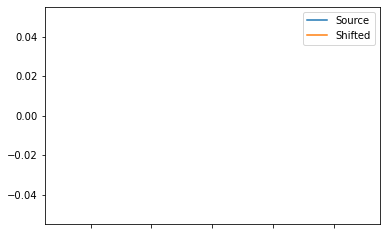

In [34]:
ax = pd.Series(puresvd_hr).plot(label='Source', legend=True)
pd.Series(shifted_puresvd_hr).plot(ax=ax, label='Shifted', legend=True)

In [35]:
puresvd_rec_array = {}
shifted_puresvd_rec_array = {}

puresvd_coverage = {}
shifted_puresvd_coverage = {}

puresvd_unique = {}
shifted_puresvd_unique = {}

for rank in svd_ranks:
    puresvd_rec_array[rank] = recs = puresvd_recs(vt[-rank:, :]).ravel()
    puresvd_coverage[rank] = np.unique(recs).size / len(item_index)
    shifted_puresvd_rec_array[rank] = s_recs = shifted_puresvd_recs(svt[-rank:, :]).ravel()
    shifted_puresvd_coverage[rank] = np.unique(s_recs).size / len(item_index)

NameError: name 'vt' is not defined

<ipython-input-36-80e7bfb152f9>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ax = pd.Series(puresvd_coverage).plot(label='Source', legend=True)
<ipython-input-36-80e7bfb152f9>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(shifted_puresvd_coverage).plot(ax=ax, label='Shifted', legend=True)


<AxesSubplot:>

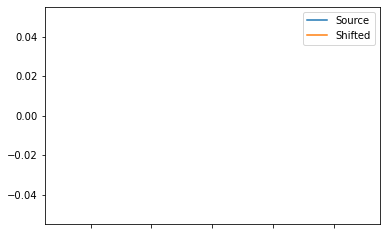

In [36]:
ax = pd.Series(puresvd_coverage).plot(label='Source', legend=True)
pd.Series(shifted_puresvd_coverage).plot(ax=ax, label='Shifted', legend=True)

In [ ]:
import seaborn as sns

In [ ]:
metrics_combined = pd.concat(
    [
        pd.concat(map(pd.Series, (puresvd_hr, puresvd_coverage)), keys=['hr', 'cov'], axis=1),
        pd.concat(map(pd.Series, (shifted_puresvd_hr, shifted_puresvd_coverage)), keys=['hr', 'cov'], axis=1),
    ],
    keys = ['source', 'shifted'],
    names = ['model', 'rank'],
    axis = 0
).reset_index()

sns.scatterplot(data=metrics_combined, x='cov', y='hr', hue='model');